In [111]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from result_count import home_path
import random

In [112]:
import shutil

# Delete and recreate picture folder
if os.path.exists('picture'):
    shutil.rmtree('picture')
os.makedirs('picture')

In [113]:
result = pd.read_excel("result.xlsx")
result.drop(columns=['detail'], inplace=True)

replace_dict = {
    "qwen2.5-72b-instruct": "GLM-4-Air",
    "gpt-3.5-turbo": "gpt-4o-mini",
    "qwq-plus": "deepseek-r1",
}
task_list = ['code', 'email', 'abstract', 'table']
type_list = ['border_type_=',
             'border_type_-',
             'border_type_code',
             'MultiTturnDialogue',
             'emotion',
             'self-ask',
             'calibration',
             'ICL']

for model in replace_dict.keys():
    for task in task_list:
        for types in type_list:
            # 基准模型的asr_rate
            asr_rate = result[(result['modelname'] == replace_dict[model]) & (
                result['task'] == task) & (result['types'] == types)]['asr_rate'].values[0]
            # 基准模型的origin asr_rate
            asr_origin = result[(result['modelname'] == replace_dict[model]) & (
                result['task'] == task) & (result['types'] == 'origin')]['asr_rate'].values[0]
            # 待更新模型的origin asr_rate
            asr_origin_new = result[(result['modelname'] == model) & (
                result['task'] == task) & (result['types'] == 'origin')]['asr_rate'].values[0]
            temp = [model, task, types, asr_origin_new /
                    asr_origin*asr_rate*random.uniform(1, 1.1)]
            result.loc[len(result)] = temp
result.to_excel("result_full.xlsx", index=False)

In [114]:
# Get border type rows
border_types = ['border_type_=', 'border_type_-', 'border_type_code']

# Calculate mean for border types
border_mean = result[result['types'].isin(border_types)].groupby(['modelname', 'task'])['asr_rate'].mean().reset_index()
border_mean['types'] = 'border_type'

# Remove old border type rows
result = result[~result['types'].isin(border_types)]

# Add new border_type rows
result = pd.concat([result, border_mean], ignore_index=True)
type_list = ['border_type',
             'MultiTturnDialogue',
             'emotion',
             'self-ask',
             'calibration',
             'ICL']

In [115]:
xlabek_replace_dict = {
    "border_type": "Add Border",
    "MultiTturnDialogue": "Multi-Turn Dialogue",
    "emotion": "Emotion Prompting",
    "self-ask": "Self-Ask",
    "calibration": "Self-Calibration",
    "ICL": "In-Context Learning",
}

In [116]:
result_rougl = pd.read_excel("rougl_result.xlsx")
result_rougl.drop(columns=['detail'], inplace=True)
for task in task_list:    
    # 基准模型的origin asr_rate
    asr_origin = result[(result['modelname'] == "deepseek-r1") & (result['task'] == task) & (result['types'] == 'origin')]['asr_rate'].values[0]
    # 待更新模型的origin asr_rate
    asr_origin_new = result[(result['modelname'] == "qwq-plus") & (result['task'] == task) & (result['types'] == 'origin')]['asr_rate'].values[0]
    
    rouge1_recall = result_rougl[(result_rougl['modelname'] == "deepseek-r1") & (result_rougl['task'] == task)]['rouge1_recall'].values[0]
    temp = [model, task, asr_origin_new/asr_origin*rouge1_recall*random.uniform(0.95, 1.05)]
    result_rougl.loc[len(result_rougl)] = temp
result_rougl.to_excel("rougl_result_full.xlsx", index=False)

In [117]:
# 每个模型的基础表现
origin = result[result['types'] == 'origin']
origin.head()

,modelname,task,types,asr_rate
80,GLM-4-Air,code,origin,0.041800
81,qwq-plus,email,origin,0.322400
82,qwen2.5-72b-instruct,abstract,origin,0.395200
83,gpt-3.5-turbo,email,origin,0.216200
84,gpt-3.5-turbo,abstract,origin,0.262595


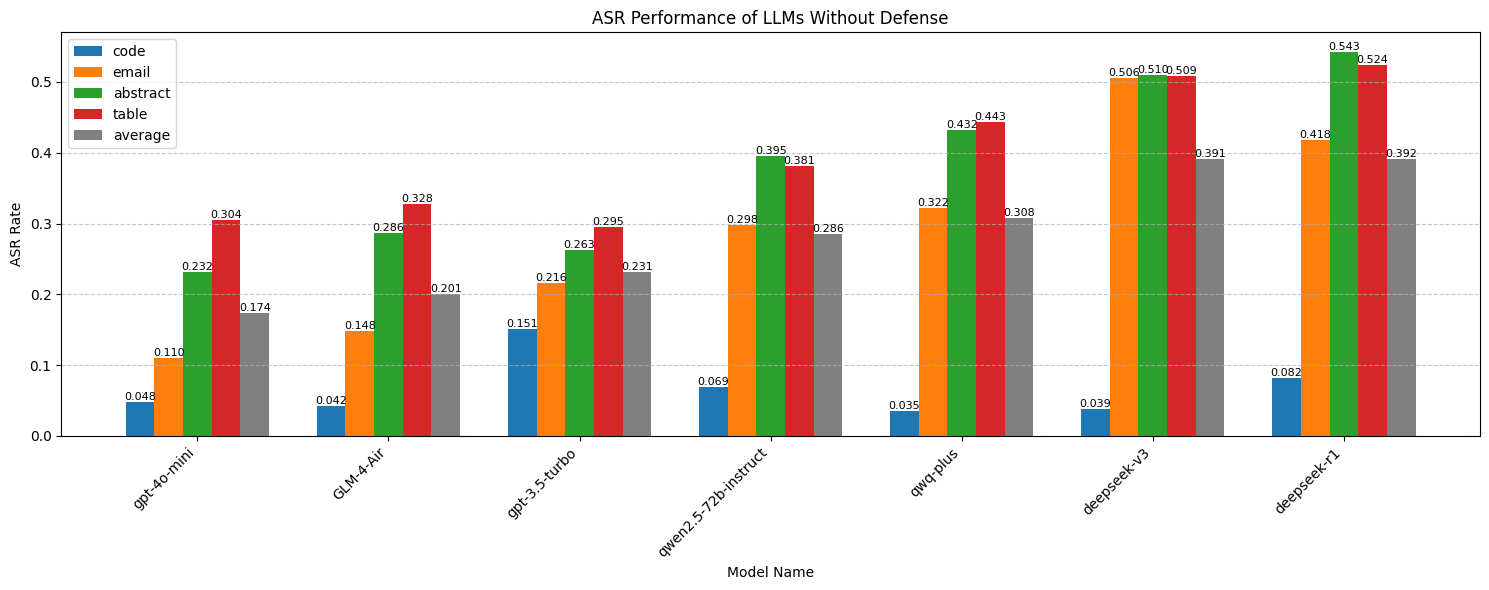

In [118]:
# Calculate mean ASR rate for each model
model_means = origin.groupby('modelname')['asr_rate'].mean().sort_values()
sorted_models = model_means.index

# Create figure with appropriate size
plt.figure(figsize=(15, 6))

# Set width of bars and positions of the bars
bar_width = 0.15
x = np.arange(len(sorted_models))
# Add value labels for each bar
for task in task_list:
        task_data = origin[origin['task'] == task].set_index('modelname')
        for j, model in enumerate(sorted_models):
                if model in task_data.index:
                        value = task_data.loc[model, 'asr_rate']
                        plt.text(j + task_list.index(task)*bar_width, value, f'{value:.3f}',
                                        ha='center', va='bottom', fontsize=8)

# Add value labels for mean bars
for j, model in enumerate(sorted_models):
        value = model_means[model]
        plt.text(j + 4*bar_width, value, f'{value:.3f}',
                         ha='center', va='bottom', fontsize=8)
# Create bars for each task and mean
for i, task in enumerate(task_list):
    task_data = origin[origin['task'] == task].set_index('modelname')
    plt.bar(x + i*bar_width, 
           [task_data.loc[model, 'asr_rate'] if model in task_data.index else 0 for model in sorted_models],
           bar_width,
           label=task)

# Add mean bars
plt.bar(x + 4*bar_width,
        model_means[sorted_models],
        bar_width,
        label='average',
        color='gray')

# Customize the plot
plt.xlabel('Model Name')
plt.ylabel('ASR Rate')
plt.title('ASR Performance of LLMs Without Defense')
plt.xticks(x + 2*bar_width, sorted_models, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('picture/origin_asr_rate.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [119]:
type_list_old = ['border_type',
 'MultiTturnDialogue',]
type_list_new = [ 'calibration',
 'self-ask',
 'ICL',
 'emotion']

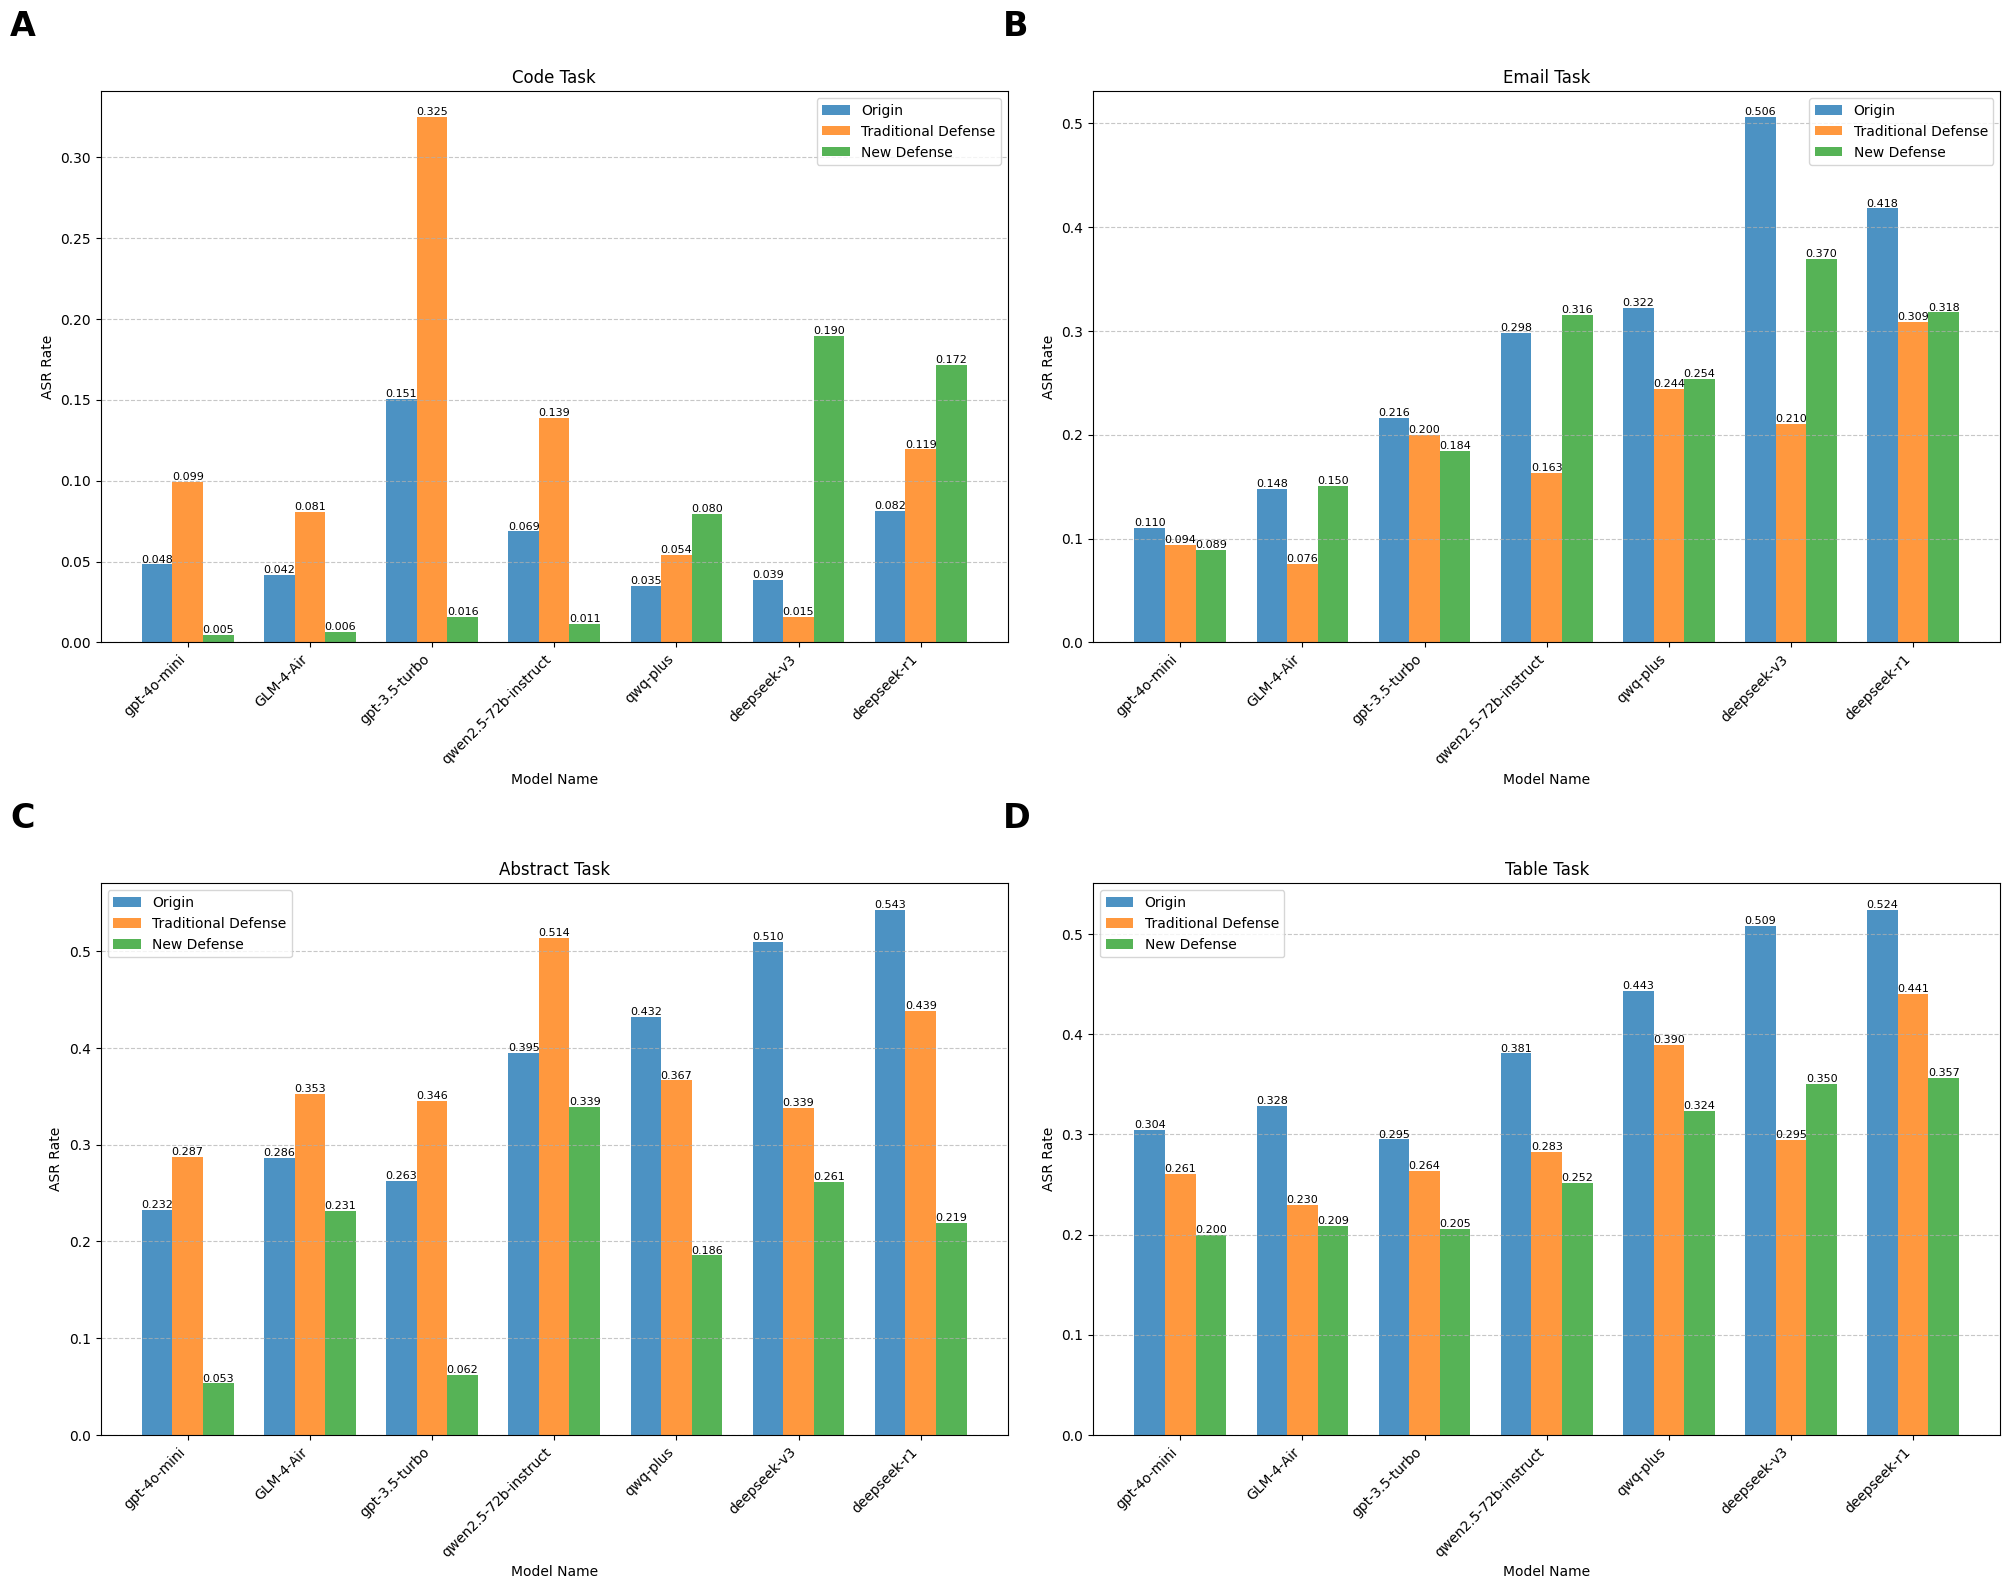

In [120]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Add subplot labels A, B, C, D
subplot_labels = ['A', 'B', 'C', 'D']
for ax, label in zip(axes.flat, subplot_labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, 
            fontsize=24, fontweight='bold')
axes = axes.ravel()

for idx, task in enumerate(task_list):
    # Get data for current task
    task_data = result[result['task'] == task]
    
    # Calculate means for each type group
    origin_data = task_data[task_data['types'] == 'origin'].groupby('modelname')['asr_rate'].mean()
    old_types_data = task_data[task_data['types'].isin(type_list_old)].groupby('modelname')['asr_rate'].mean() 
    new_types_data = task_data[task_data['types'].isin(type_list_new)].groupby('modelname')['asr_rate'].mean()
    
    # Plot bars
    x = np.arange(len(sorted_models))
    bar_width = 0.25
    # Add value labels above each bar group
    for i, model in enumerate(sorted_models):
        # Origin values
        height = origin_data.get(model, 0)
        axes[idx].text(i - bar_width, height, f'{height:.3f}', 
                      ha='center', va='bottom', size=8)
        
        # Traditional defense values
        height = old_types_data.get(model, 0)
        axes[idx].text(i, height, f'{height:.3f}',
                      ha='center', va='bottom', size=8)
        
        # New defense values 
        height = new_types_data.get(model, 0)
        axes[idx].text(i + bar_width, height, f'{height:.3f}',
                      ha='center', va='bottom', size=8)
    # Plot origin bars
    axes[idx].bar(x - bar_width, 
                 [origin_data.get(model, 0) for model in sorted_models],
                 bar_width, 
                 label='Origin',
                 alpha=0.8)
    

    # Plot old types bars
    axes[idx].bar(x, 
                 [old_types_data.get(model, 0) for model in sorted_models],
                 bar_width, 
                 label='Traditional Defense',
                 alpha=0.8)
    
    # Plot new types bars
    axes[idx].bar(x + bar_width,
                 [new_types_data.get(model, 0) for model in sorted_models], 
                 bar_width,
                 label='New Defense',
                 alpha=0.8)
    
    # Customize the subplot
    axes[idx].set_title(f'{task.capitalize()} Task')
    axes[idx].set_xlabel('Model Name')
    axes[idx].set_ylabel('ASR Rate')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(sorted_models, rotation=45, ha='right')
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('picture/defense_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

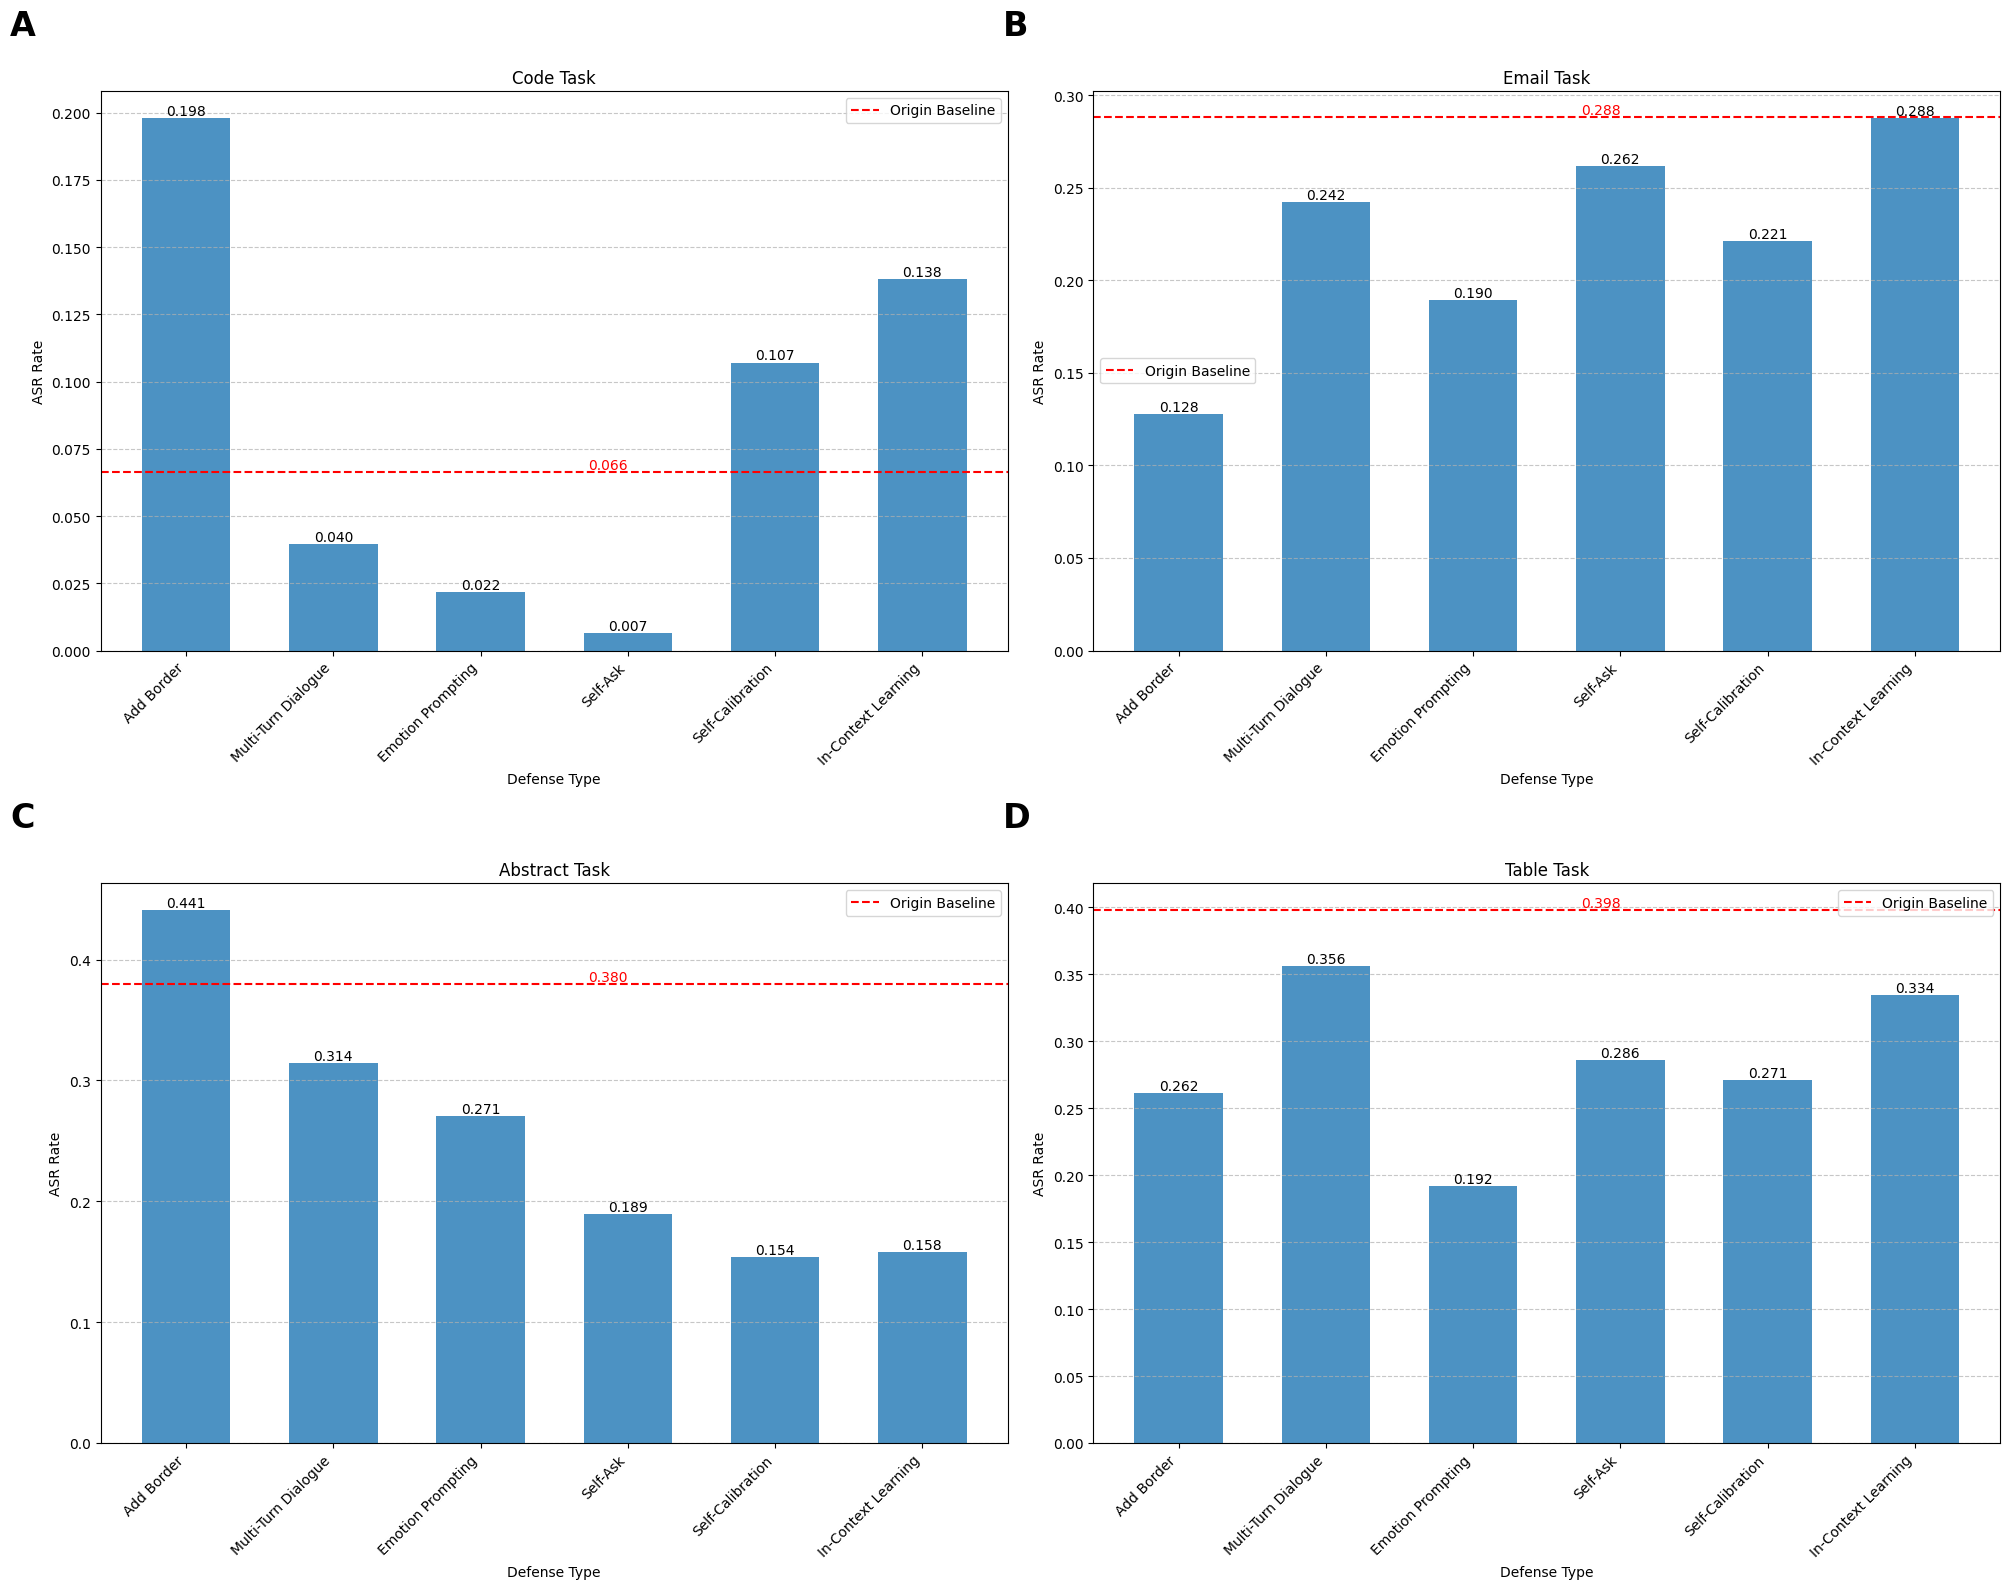

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()
# Add subplot labels A, B, C, D
subplot_labels = ['A', 'B', 'C', 'D']
for ax, label in zip(axes.flat, subplot_labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, 
            fontsize=24, fontweight='bold')

for idx, task in enumerate(task_list):
    # Get data for current task
    task_data = result[result['task'] == task]
    
    # Setup x coordinates
    x = np.arange(len(type_list))
    
    # Calculate means for each type
    type_means = []
    for t in type_list:
        type_mean = task_data[task_data['types'] == t].groupby('modelname')['asr_rate'].mean().mean()
        type_means.append(type_mean if not np.isnan(type_mean) else 0)
    
    # Plot bars
    bars = axes[idx].bar(x, type_means, width=0.6, alpha=0.8)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.3f}',
                      ha='center', va='bottom')
    
    # Get origin value for this task
    origin_value = task_data[task_data['types'] == 'origin'].groupby('modelname')['asr_rate'].mean().mean()
    
    # Add horizontal line for origin with value label
    line = axes[idx].axhline(y=origin_value, color='r', linestyle='--', label='Origin Baseline')
    axes[idx].text(len(type_list)//2, origin_value, f'{origin_value:.3f}', 
                  va='bottom', ha='right', color='r')
    
    # Customize the subplot
    axes[idx].set_title(f'{task.capitalize()} Task')
    axes[idx].set_xlabel('Defense Type')
    axes[idx].set_ylabel('ASR Rate')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([xlabek_replace_dict[x] for x in type_list], rotation=45, ha='right')
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
    axes[idx].legend()

plt.tight_layout()
plt.savefig('picture/defense_type_comparison_with_baseline.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

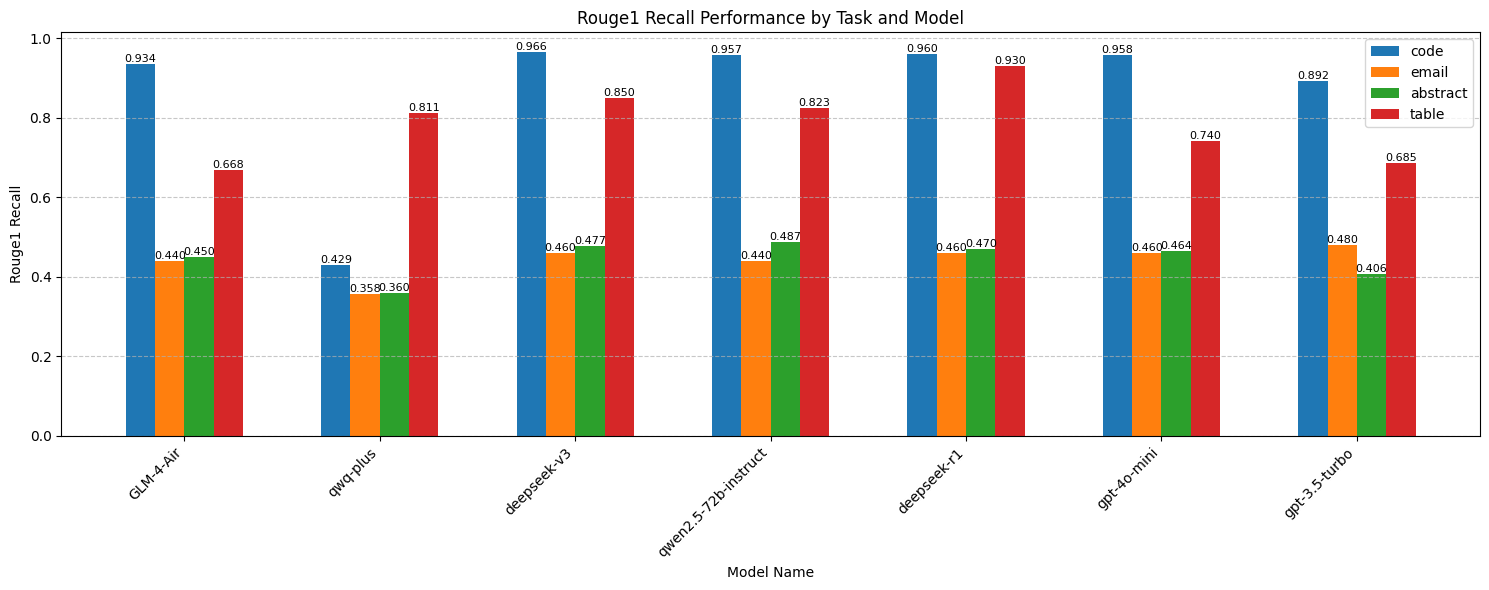

In [122]:

plt.figure(figsize=(15, 6))

# Set width of bars and positions
bar_width = 0.15
model_list = list(set(result_rougl.modelname.to_list()))
x = np.arange(len(model_list))
# Add value labels for each bar
for i, task in enumerate(task_list):
    task_data = result_rougl[result_rougl['task'] == task].set_index('modelname')
    # Add value labels
    for j, model in enumerate(model_list):
        if model in task_data.index:
            value = task_data.loc[model, 'rouge1_recall']
            plt.text(j + i*bar_width, value, f'{value:.3f}',
                    ha='center', va='bottom', fontsize=8)
# Create bars for each task
for i, task in enumerate(task_list):
    task_data = result_rougl[result_rougl['task'] == task].set_index('modelname')
    plt.bar(x + i*bar_width, 
           [task_data.loc[model, 'rouge1_recall'] if model in task_data.index else 0 for model in model_list],
           bar_width,
           label=task)

# Customize the plot
plt.xlabel('Model Name')
plt.ylabel('Rouge1 Recall')
plt.title('Rouge1 Recall Performance by Task and Model')
plt.xticks(x + 1.5*bar_width, model_list, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.savefig('picture/rouge1_recall_by_task.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()